<a href="https://colab.research.google.com/github/aadvikchaturvedi/Sentiment-Analysis-Model/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
path=kagglehub.dataset_download("bhavikjikadara/emotions-dataset")
print("Path to dataset files:",path)

100%|██████████| 14.5M/14.5M [00:00<00:00, 153MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/emotions-dataset/versions/1


## <strong>Text: Description of context</strong>
label: The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

1.   List item
2.   List item



In [3]:
import pandas as pd
import os

# Checking files inside the dataset folder
dataset_path="/root/.cache/kagglehub/datasets/bhavikjikadara/emotions-dataset/versions/1"
print(os.listdir(dataset_path))

df=pd.read_csv(os.path.join(dataset_path,"emotions.csv"))

['emotions.csv']


In [4]:
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
df.shape

(416809, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [7]:
df['label'].value_counts()

,count
label,
1,141067
0,121187
3,57317
4,47712
2,34554
5,14972


In [8]:
df.isnull().sum()

,0
text,0
label,0


In [9]:
df.duplicated().sum()

np.int64(686)

In [10]:
df_cleaned=df.drop_duplicates()

In [11]:
df_cleaned.shape

(416123, 2)

In [12]:
# Train-test split

In [13]:
from sklearn.model_selection import train_test_split

X=df_cleaned['text']
Y=df_cleaned['label']

# Stratified splitting (80:20 ratio)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=42)

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

stemmer=PorterStemmer()
stop_words=set(stopwords.words('english'))

def preprocess_text(text):
    # Remove URLs
    text=re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text=re.sub(r'@\w+', '', text)
    # Remove special characters and numbers
    text=re.sub(r'[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text=text.lower()
    # Tokenize
    tokens=text.split()
    # Remove stop words and stem
    processed_text=' '.join([stemmer.stem(word) for word in tokens if word not in stop_words])
    return processed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
X_train_processed=X_train.apply(preprocess_text)
X_test_processed=X_test.apply(preprocess_text)

In [16]:
X_train_processed.head()

,text
255286,feel love href http thesmallhousefamili
131412,love say loud feel never got shi
90992,feel suspici im happi
19338,feel defeat readi done ill stuff
172790,look someon hate someon feel sorri


In [17]:
X_train_processed.shape

(332898,)

In [18]:
Y_train.head()

,label
255286,2
131412,4
90992,4
19338,0
172790,0


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_features=5000)


X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)


X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

print("TF-IDF transformed training data shape:", X_train_tfidf.shape)
print("TF-IDF transformed test data shape:", X_test_tfidf.shape)

TF-IDF transformed training data shape: (332898, 5000)
TF-IDF transformed test data shape: (83225, 5000)


In [20]:
from xgboost import XGBClassifier

model = XGBClassifier(objective='multi:softmax',
                      num_class=6,
                      eval_metric='mlogloss',
                      use_label_encoder=False
                      )

model.fit(X_train_tfidf, Y_train)

print("Model training complete.")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:26:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete.


In [21]:
predictValues = model.predict(X_test_tfidf)
print(predictValues)

[0 0 1 ... 0 3 1]


In [22]:
dictionary = {
    0 : "sad",
    1 : "joy",
    2 : "love",
    3 : "anger",
    4 : "fear",
    5 : "surprise"
}
ind = 0
labelled_predict = []
for val in predictValues:
  labelled_predict.append(dictionary[val])
print(labelled_predict[:6])


['sad', 'sad', 'joy', 'joy', 'anger', 'joy']


In [24]:
from sklearn.metrics import accuracy_score
print(accuracy_score(predictValues, Y_test))

0.8744007209372184


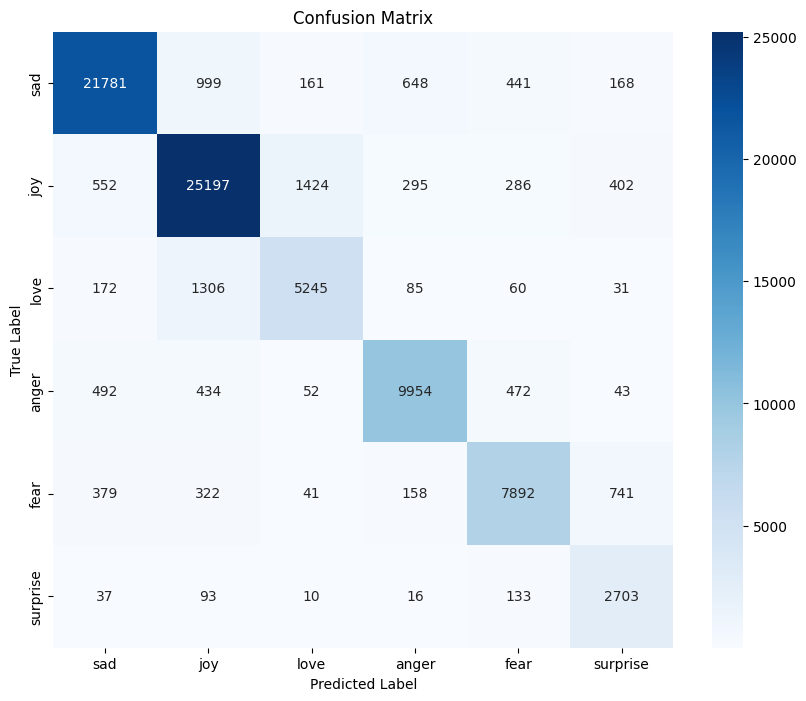

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_test, predictValues)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dictionary.values(), yticklabels=dictionary.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()